In [1]:
import cv2
import os
import numpy as np
import pandas as pd
from PIL import Image
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Path ke folder dataset
data_dir = '/content/drive/MyDrive/PCD Proyek/valid'
labels_df = pd.read_csv('/content/drive/MyDrive/PCD Proyek/class_valid.csv')

# Cek jumlah gambar di setiap kelas
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        print(f"Jumlah gambar di kelas {folder}: {len(os.listdir(folder_path))}")

Jumlah gambar di kelas rotten: 500
Jumlah gambar di kelas unrotten: 500


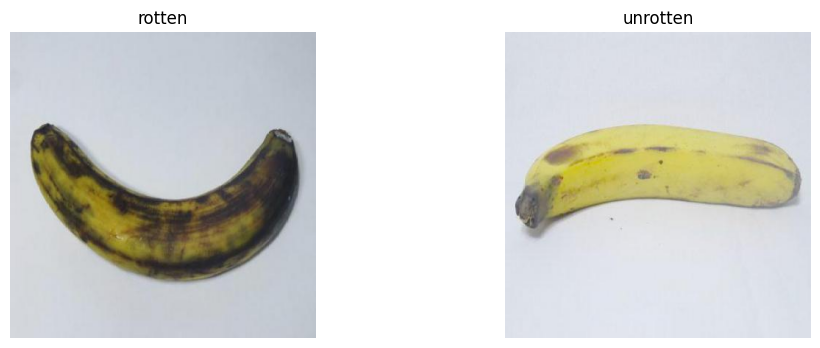

In [3]:
# Tampilkan contoh gambar random dari tiap kelas
plt.figure(figsize=(15, 10))

class_names = os.listdir(data_dir)
for i, class_name in enumerate(class_names):
    class_folder = os.path.join(data_dir, class_name)
    img_name = random.choice(os.listdir(class_folder))
    img_path = os.path.join(class_folder, img_name)

    img = mpimg.imread(img_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Inisialisasi counter
count_416 = 0
count_other = 0

# Loop kedua subfolder: rotten dan unrotten
for subfolder in ['rotten', 'unrotten']:
    folder_path = os.path.join(data_dir, subfolder)
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.jpg'):
            path = os.path.join(folder_path, filename)
            try:
                with Image.open(path) as img:
                    width, height = img.size
                    if (width, height) == (416, 416):
                        count_416 += 1
                    else:
                        count_other += 1
            except Exception as e:
                print(f"[Error] Gagal membuka {filename} di {subfolder}: {e}")

# Output hasil akhir
print(f"Jumlah gambar berukuran 416x416: {count_416}")
print(f"Jumlah gambar dengan ukuran lain: {count_other}")

Jumlah gambar berukuran 416x416: 1000
Jumlah gambar dengan ukuran lain: 0


Seluruh image sudah dalam keadaan ukuran yang sama yaitu 416x416, tidak perlu melakukan resize

#Preprocessing

Augmentasi

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [25]:
# Ambil semua file dengan label dari nama folder
filepaths = []
labels = []

for label in ['unrotten', 'rotten']:
    folder = os.path.join(data_dir, label)
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg')):
            filepaths.append(f"{label}/{fname}")  # relatif terhadap data_dir
            labels.append(label)

# Buat dataframe
df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

In [26]:
# Split 80% train_val, 20% test
train_val_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Split 80% train, 20% val dari train_val
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    stratify=train_val_df['label'],
    random_state=42
)
# Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# flow_from_dataframe dengan kolom 'filepath'
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=data_dir,
    x_col='filepath',
    y_col='label',
    classes=['unrotten', 'rotten'],
    target_size=(416, 416),
    batch_size=32,
    class_mode='binary',
    seed=42
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    directory=data_dir,
    x_col='filepath',
    y_col='label',
    classes=['unrotten', 'rotten'],
    target_size=(416, 416),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    directory=data_dir,
    x_col='filepath',
    y_col='label',
    classes=['unrotten', 'rotten'],
    target_size=(416, 416),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 640 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [23]:
print("Train:", train_generator.samples)
print("Val:", val_generator.samples)
print("Test:", test_generator.samples)


Train: 640
Val: 160
Test: 200


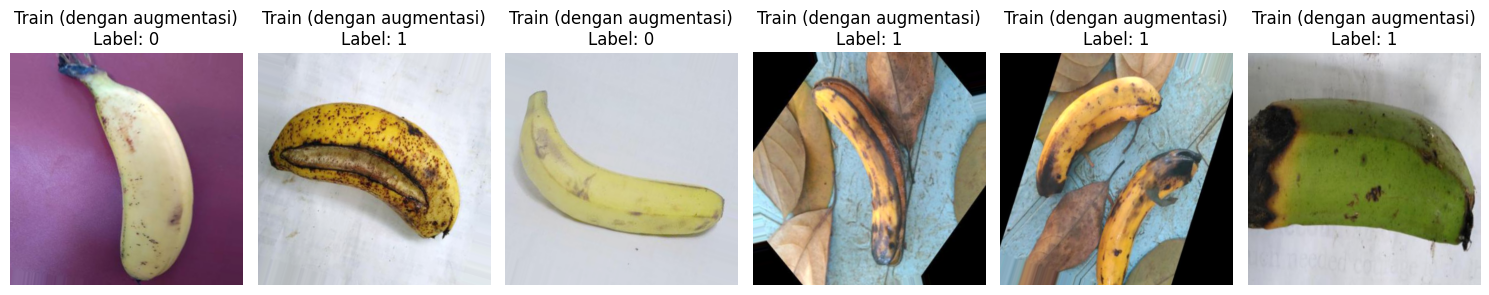

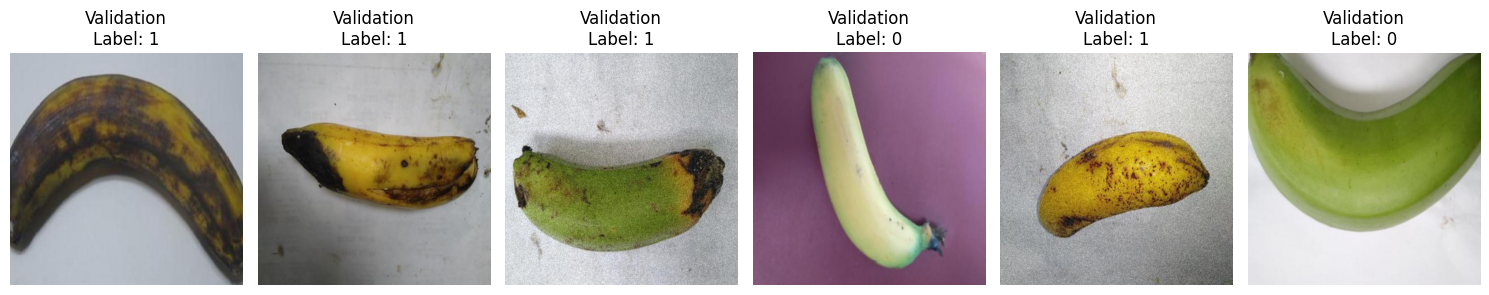

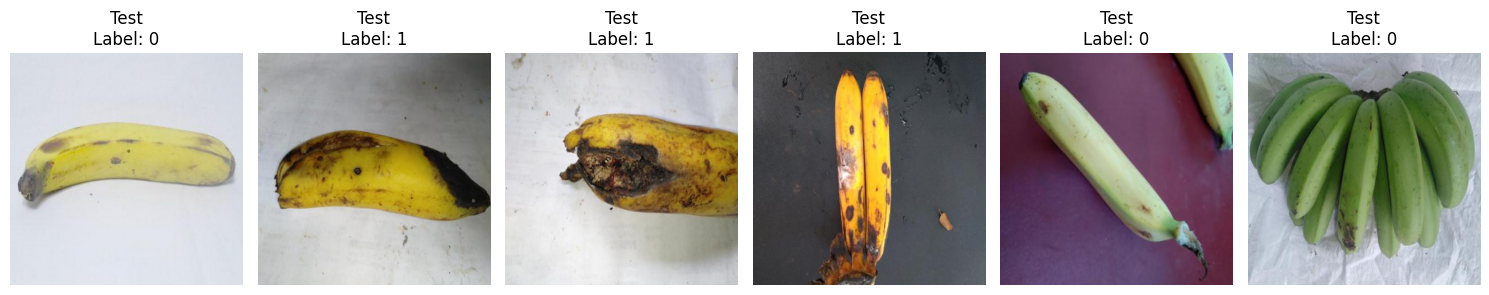

In [27]:
# Fungsi bantu untuk menampilkan batch gambar dari generator
def show_images_from_generator(generator, title, n_images=6):
    images, labels = next(generator)  # ambil 1 batch
    plt.figure(figsize=(15, 5))
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        plt.imshow(images[i])
        plt.title(f"{title}\nLabel: {int(labels[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Reset generator agar tidak skip data (penting jika sudah dipakai sebelumnya)
train_generator.reset()
val_generator.reset()
test_generator.reset()

# Tampilkan masing-masing 6 gambar dari train, val, dan test
show_images_from_generator(train_generator, "Train (dengan augmentasi)", n_images=6)
show_images_from_generator(val_generator, "Validation", n_images=6)
show_images_from_generator(test_generator, "Test", n_images=6)

rotten : 1, unrotten : 0

In [33]:
import shutil

# Path asal data dan tujuan
source_dir = data_dir
output_base_dir = '/content/drive/MyDrive/PCD Proyek/Model'

# Pastikan folder output ada
os.makedirs(output_base_dir, exist_ok=True)

In [34]:
# Label ke angka
label_map = {'unrotten': 0, 'rotten': 1}

# Fungsi salin file + buat label .txt
def copy_with_label(df, subset_name):
    # Buat folder subset
    subset_dir = os.path.join(output_base_dir, subset_name)

    # Buat subfolder images dan labels
    images_dir = os.path.join(subset_dir, 'images')
    labels_dir = os.path.join(subset_dir, 'labels')

    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for _, row in df.iterrows():
        # Path file gambar sumber
        src_path = os.path.join(source_dir, row['filepath'])

        # Path tujuan file gambar
        dst_img_path = os.path.join(images_dir, os.path.basename(row['filepath']))
        shutil.copyfile(src_path, dst_img_path)

        # Path file label .txt
        base_filename = os.path.splitext(os.path.basename(row['filepath']))[0]
        label_txt_path = os.path.join(labels_dir, base_filename + '.txt')

        # Ambil label numerik dan tulis ke file .txt
        label_value = label_map[row['label']]
        with open(label_txt_path, 'w') as f:
            f.write(str(label_value))



In [35]:
# Jalankan untuk masing-masing bagian
copy_with_label(train_df, 'train')

In [36]:
copy_with_label(val_df, 'valid')
copy_with_label(test_df, 'test')